In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
dat = pd.read_csv('app_overview.csv')

## Glance on data

In [3]:
dat.head()

,domain,cat,sub
0,hangouts.google.com,Communication,Chat
1,slack.com,Communication,Chat
2,messenger.com,Communication,Chat
3,skype.com,Communication,Chat
4,hipchat.com,Communication,Chat


In [4]:
# Change column name from " cat" to "cat" and " sub" to "subcat"
dat.rename_axis({dat.columns[1]:'cat'},axis=1,inplace=True)
dat.rename_axis({dat.columns[2]:'subcat'},axis=1,inplace=True)

In [5]:
new_dat = dat.copy(deep=True)

In [6]:
counterize = CountVectorizer(ngram_range=(3,6),analyzer='char').build_analyzer()

In [7]:
onehot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()
new_dat['cat'] = label_encoder.fit_transform(dat['cat'])
new_dat['subcat'] = label_encoder.fit_transform(dat['subcat'])

## URL Domain split

In [8]:
# Url with format xxx.xxx or xxx.yyy.zzz
def split_webname(url):
    return url.split('.')[0]

In [10]:
new_dat['domain'] = dat.domain.map(lambda d: split_webname(d))

## Count top term each category

In [11]:
# words_ngram = np.array([counterize(word).flatten() for word in new_dat.domain])
def count_topic_gram(dat):
    words_ngram = []
    for word in dat:
        words_ngram.extend(counterize(word))
    words_ngram = np.array(words_ngram)
    return pd.DataFrame(zip(*np.unique(words_ngram,return_counts=True)),columns=['term','tf'])

chat_topic = count_topic_gram(new_dat[new_dat.cat==0]['domain'])
share_topic = count_topic_gram(new_dat[new_dat.cat==1]['domain'])

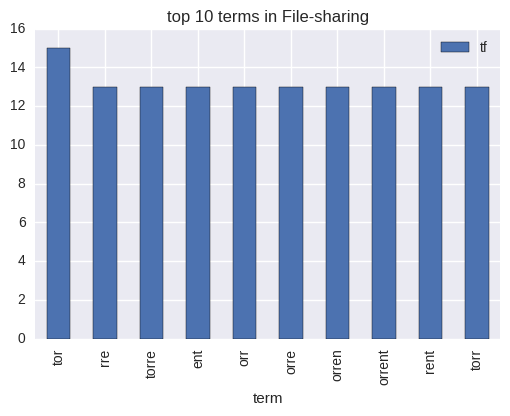

In [23]:
%matplotlib inline
share_topic.sort_values(['tf'],ascending=False)[:10].set_index(['term']).plot(kind='bar',title='top 10 terms in File-sharing')

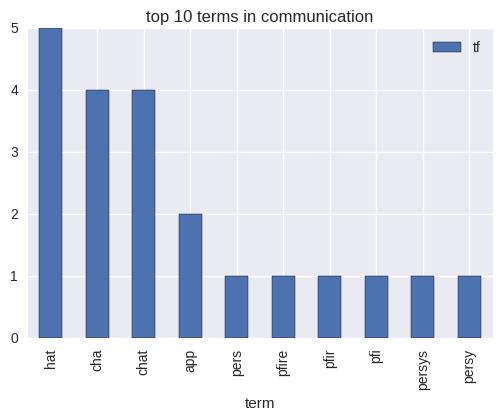

In [22]:
%matplotlib inline
chat_topic.sort_values(['tf'],ascending=False)[:10].set_index(['term']).plot(kind='bar',title='top 10 terms in communication')

# Preparing dataset

In [14]:
Xr_train, Xr_val, yr_train, yr_val = train_test_split(new_dat['domain'],new_dat['cat'],train_size=0.7,
                                                      stratify=new_dat['cat'],random_state=4111)

# Model Learning

## Tf-idf weighting

In [15]:
tfidfVec = TfidfVectorizer(analyzer='char',sublinear_tf=True,stop_words=None)

## Train with tf-idf

In [16]:
# model = MultinomialNB()
# model.fit(X_tf_train,y_tf_train)
# print model.score(X_tf_val,y_tf_val)
# estimator = MultinomialNB()
estimator = LogisticRegression()
url_predict = Pipeline([('vec', tfidfVec), ('linear', estimator)])

In [17]:
param_grid = {
    'linear__C':[0.001,0.01,0.1,1.0,10,100,1000],
#     'linear__alpha':[0.001,0.01,0.1,1.0,10,100,1000],
    'vec__ngram_range':[(1,5),(1,6),(2,6),(3,6),(3,3),(4,4),(2,2),(3,5),(4,6),(4,4),(3,8)],
}
gridSearch = GridSearchCV(estimator=url_predict,param_grid=param_grid,n_jobs=-1,scoring='f1',cv=5)
gridSearch.fit(Xr_train,yr_train)
print gridSearch.best_estimator_
gridSearch.score(Xr_val,yr_val)

Pipeline(steps=[('vec', TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(3, 6), norm=u'l2', preprocessor=None, smooth_idf=True,
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


0.8571428571428571

In [18]:
all_probs = np.array([ max(prob) for prob in gridSearch.predict_proba(new_dat['domain'])])

In [19]:
# p-value > 50%
threshold = all_probs.mean() - all_probs.std()
print "Threshold = %s"%threshold

Threshold = 0.751300022784


In [20]:
def check_threshold_other(log_proba):
    prob = max(log_proba)
    if prob < threshold:
        return 2
    return log_proba.argmax()

In [21]:
joblib.dump(gridSearch.best_estimator_,'url_predict.model')

['url_predict.model']